Importing Libraries

In [1]:
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org matplotlib
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org seaborn 
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org plotly
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org statsmodels
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org pmdarima
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org holidays

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from math import sqrt

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error,mean_squared_error

from pandas.tseries.holiday import get_calendar, HolidayCalendarFactory, GoodFriday
from datetime import date

from sklearn.preprocessing import MinMaxScaler
import holidays
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

Data Understanding

In [9]:
df = pd.read_csv("data.csv", parse_dates=True, low_memory=False, index_col='Date')
store = pd.read_csv("store.csv", low_memory=False)

# new features
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['SalePerCustomer'] = df['Sales'] / df['Customers']
df.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  Year  Month  Day  SalePerCustomer  
Date                                                          
2015-07-31              1  2015      7   31         9.482883  
2015-07-31              1  2015      7   31         9.702400  
2015-07-31              1  2015      7   31        10.126675  
2015-07-31              1  2015      7   31         9.342457  
2015-07-31              1  2015      7   31         8.626118

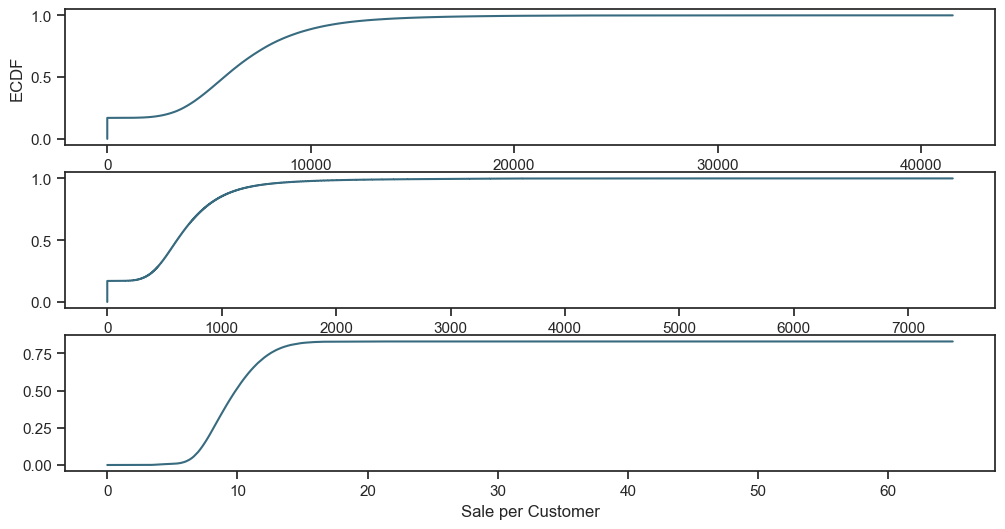

In [10]:
sns.set(style="ticks")
c = '#386B7F'
plt.figure(figsize=(12, 6))

plt.subplot(311)
cdf = ECDF(df['Sales'])
plt.plot(cdf.x, cdf.y, label="statmodels", color=c)
plt.xlabel('Sales')
plt.ylabel('ECDF')

plt.subplot(312)
cdf = ECDF(df['Customers'])
plt.plot(cdf.x, cdf.y, label="statmodels", color=c)
plt.xlabel('Customers')

plt.subplot(313)
cdf = ECDF(df['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label="statmodels", color=c)
plt.xlabel('Sale per Customer')

plt.show()

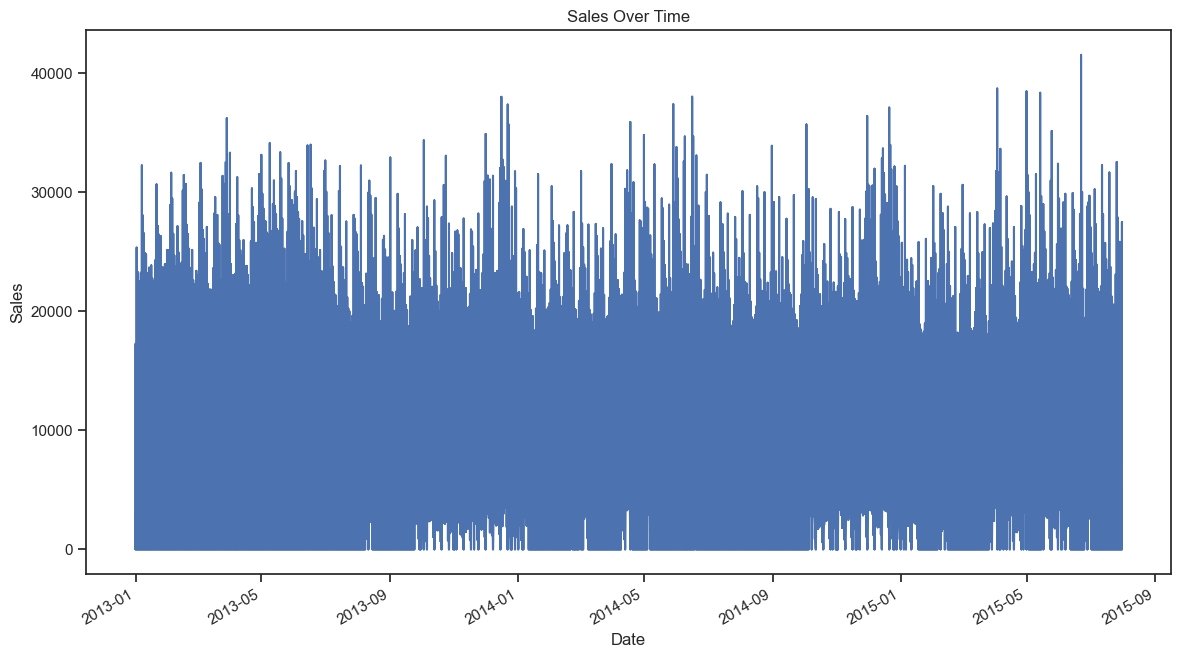

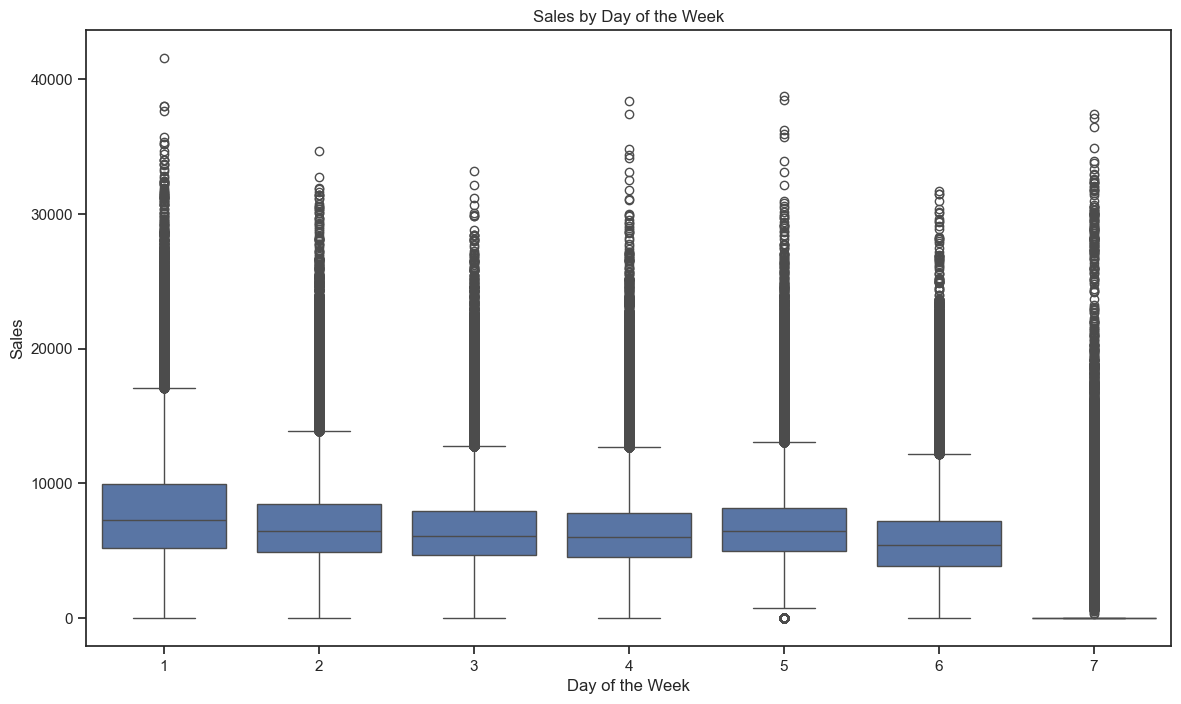

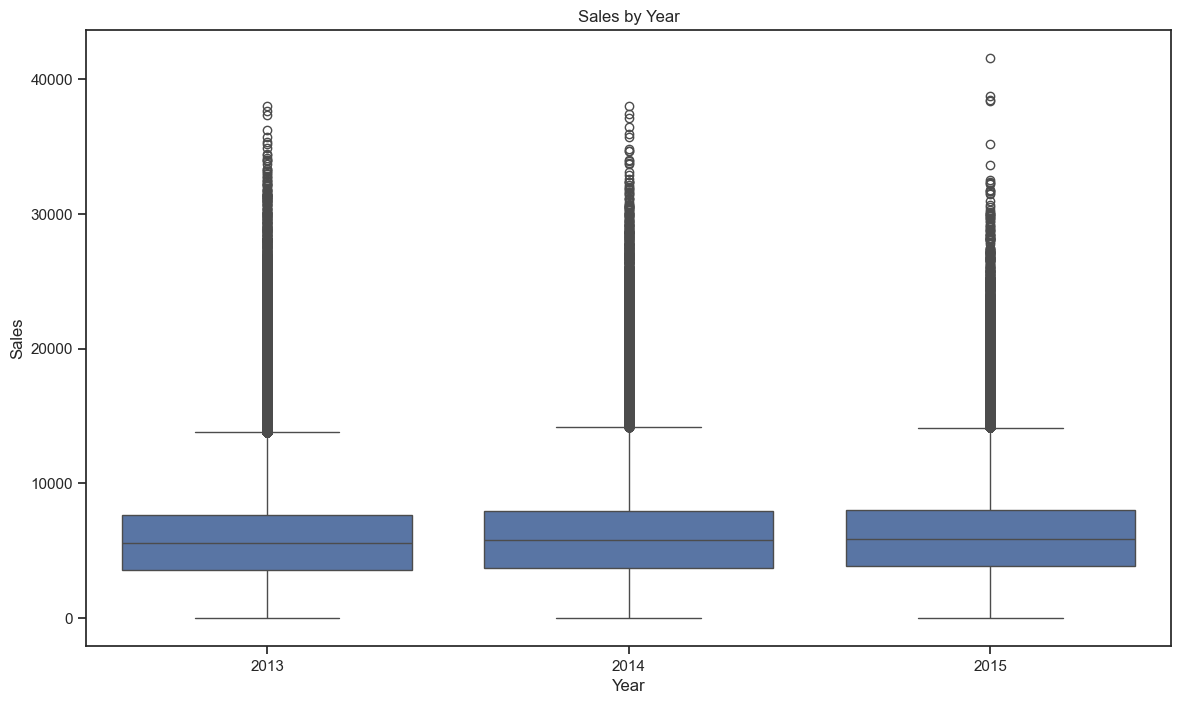

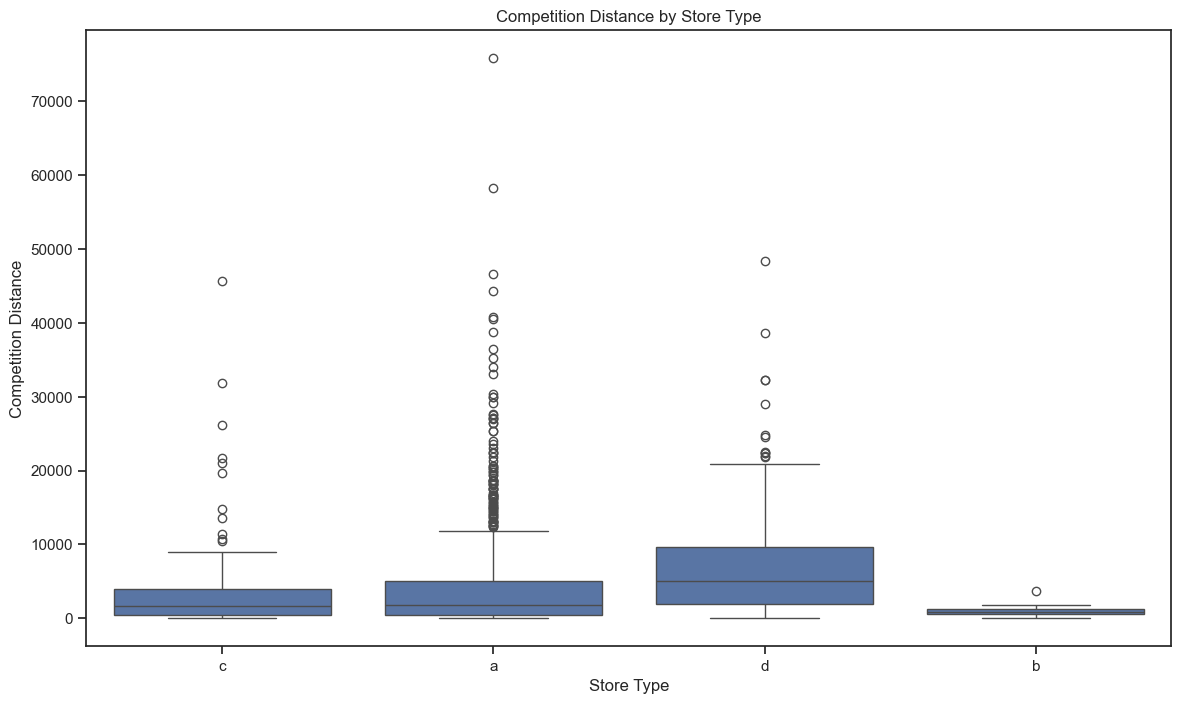

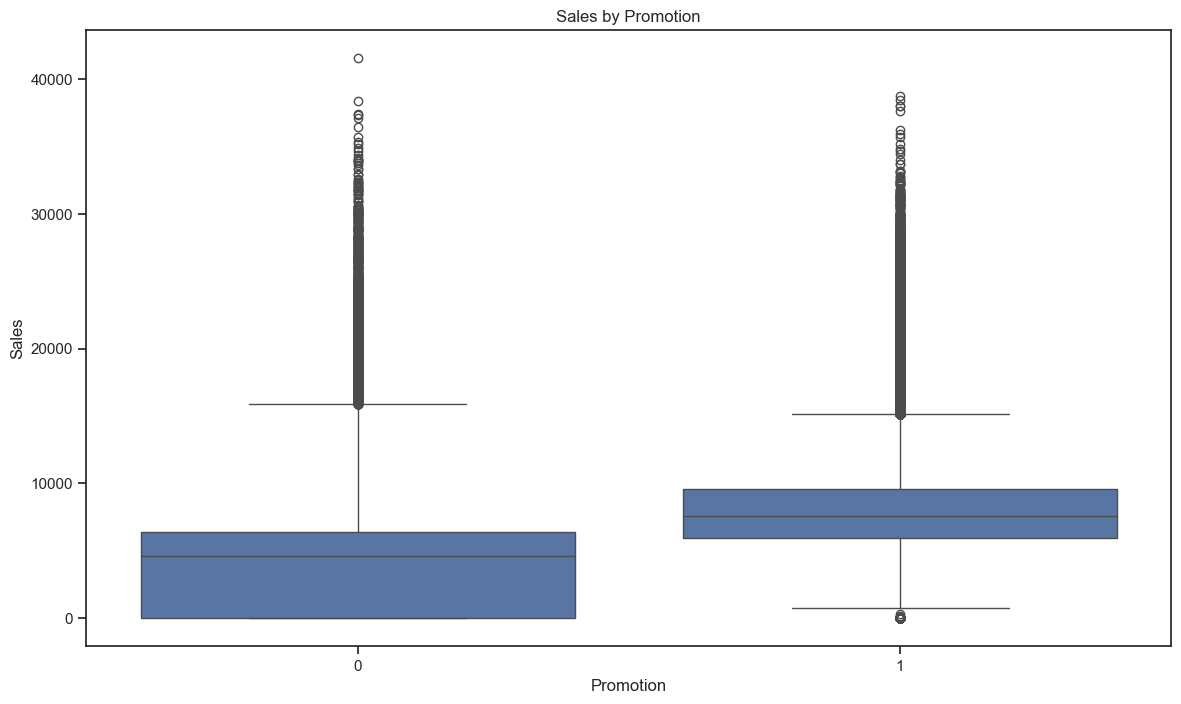

In [11]:
# Sales distribution over time
plt.figure(figsize=(14, 8))
df['Sales'].plot()
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Sales distribution by day of the week
plt.figure(figsize=(14, 8))
sns.boxplot(x='DayOfWeek', y='Sales', data=df)
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.show()

# Sales distribution by year
plt.figure(figsize=(14, 8))
sns.boxplot(x='Year', y='Sales', data=df)
plt.title('Sales by Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

# Competition distance by store type
plt.figure(figsize=(14, 8))
sns.boxplot(x='StoreType', y='CompetitionDistance', data=store)
plt.title('Competition Distance by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Competition Distance')
plt.show()

# Effect of promotions
plt.figure(figsize=(14, 8))
sns.boxplot(x='Promo', y='Sales', data=df)
plt.title('Sales by Promotion')
plt.xlabel('Promotion')
plt.ylabel('Sales')
plt.show()

Data Preparation 

In [12]:
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)
store.fillna(0, inplace=True)

# Data collection
df_merged = pd.merge(df, store, on='Store', how='inner')
df_merged

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0           1          5   5263        555     1      1            0   
1           1          4   5020        546     1      1            0   
2           1          3   4782        523     1      1            0   
3           1          2   5011        560     1      1            0   
4           1          1   6102        612     1      1            0   
...       ...        ...    ...        ...   ...    ...          ...   
844333    292          1   9291       1002     1      1            0   
844334    292          6   2748        340     1      0            0   
844335    292          5   4202        560     1      0            0   
844336    292          4   4580        662     1      0            0   
844337    292          3   5076        672     1      0            0   

        SchoolHoliday  Year  Month  ...  SalePerCustomer  StoreType  \
0                   1  2015      7  ...         9.482883          c   
1                   1  2015      7  ...         9.194139          c   
2                   1  2015      7  ...         9.143403          c   
3                   1  2015      7  ...         8.948214          c   
4                   1  2015      7  ...         9.970588          c   
...               ...   ...    ...  ...              ...        ...   
844333              0  2013      1  ...         9.272455          a   
844334              0  2013      1  ...         8.082353          a   
844335              1  2013      1  ...         7.503571          a   
844336              1  2013      1  ...         6.918429          a   
844337              1  2013      1  ...         7.553571          a   

       Assortment CompetitionDistance  CompetitionOpenSinceMonth  \
0               a              1270.0                        9.0   
1               a              1270.0                        9.0   
2               a              1270.0                        9.0   
3               a              1270.0                        9.0   
4               a              1270.0                        9.0   
...           ...                 ...                        ...   
844333          a              1100.0                        6.0   
844334          a              1100.0                        6.0   
844335          a              1100.0                        6.0   
844336          a              1100.0                        6.0   
844337          a              1100.0                        6.0   

        CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                         2008.0       0              0.0              0.0   
1                         2008.0       0              0.0              0.0   
2                         2008.0       0              0.0              0.0   
3                         2008.0       0              0.0              0.0   
4                         2008.0       0              0.0              0.0   
...                          ...     ...              ...              ...   
844333                    2009.0       0              0.0              0.0   
844334                    2009.0       0              0.0              0.0   
844335                    2009.0       0              0.0              0.0   
844336                    2009.0       0              0.0              0.0   
844337                    2009.0       0              0.0              0.0   

        PromoInterval  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
844333              0  
844334              0  
844335              0  
844336              0  
844337              0  

[844338 rows x 21 columns]

Modelling

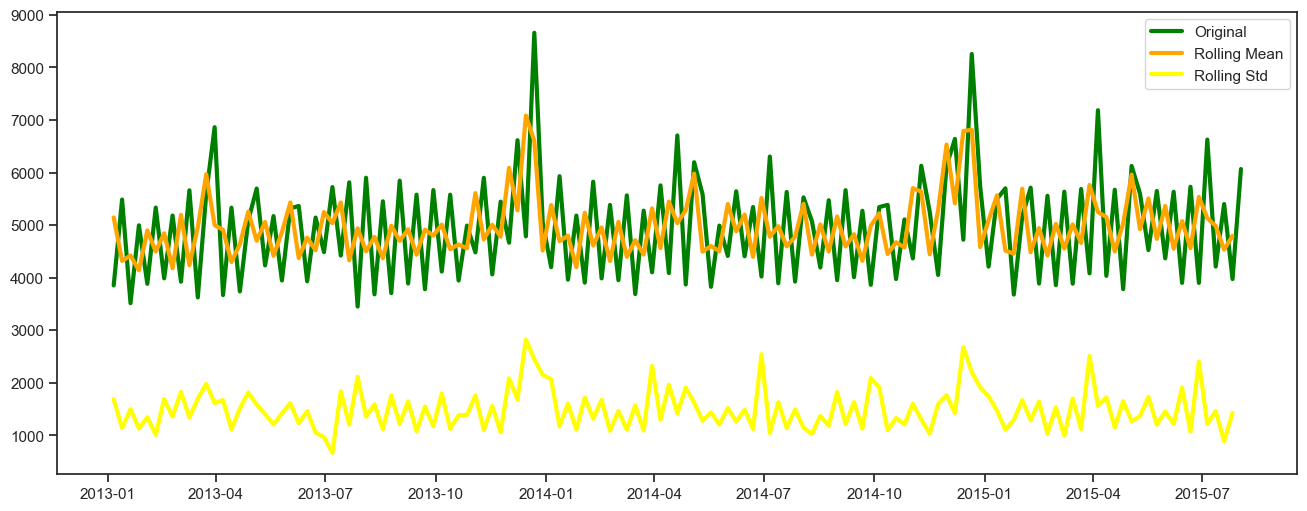

ADF Statistics: -5.292708
P-value: 0.000006
1% -3.438915730045254
5% -2.8653205426302253
10% -2.5687831424305845


In [13]:
def test_stationarity(timeseries):
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
    
    plt.subplots(figsize=(16, 6))
    plt.plot(timeseries.resample('w').mean(), color='green', linewidth=3, label='Original')
    plt.plot(roll_mean.resample('w').mean(), color='orange', linewidth=3, label='Rolling Mean')
    plt.plot(roll_std.resample('w').mean(), color='yellow', linewidth=3, label='Rolling Std')
    plt.legend(loc='best')
    plt.show()
    
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistics: %f' % result[0])
    print('P-value: %f' % result[1])
    for key, value in result[4].items():
        print(key, value)

# Testing for one store group
sales_a = df[df.Store == 2]['Sales']
test_stationarity(sales_a)



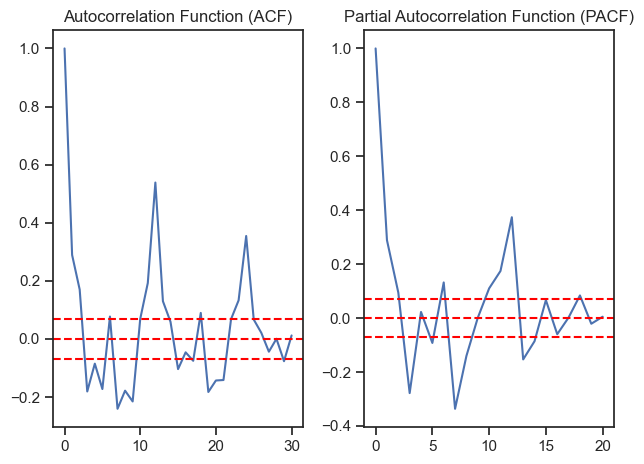

In [16]:
# Autocorrelation and Partial Autocorrelation Analysis
def auto_corr(sales):
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales, nlags=20, method='ols')
    
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('Autocorrelation Function (ACF)')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()
auto_corr(sales_a)


In [17]:
# ARIMA Model
df_arima = df[['Sales']].copy()
df_arima = df_arima.resample('w').mean()

model = auto_arima(df_arima, seasonal=True, m=12, suppress_warnings=True)
print("ARIMA Order:", model.order)
print("Seasonal Order:", model.seasonal_order)

model_arima = ARIMA(df_arima, order=model.order)
results_arima = model_arima.fit()

# SARIMA model
model_sarima = SARIMAX(df_arima, order=model.order, seasonal_order=model.seasonal_order)
results_sarima = model_sarima.fit()

ARIMA Order: (4, 1, 1)
Seasonal Order: (0, 0, 1, 12)


Model Evaluations

In [18]:
pred_arima = results_arima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)
train_arima_forecasted = pred_arima.predicted_mean
train_arima_truth = df_arima['2015-01-04':]

pred_sarima = results_sarima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)
train_sarima_forecasted = pred_sarima.predicted_mean
train_sarima_truth = df_arima['2015-01-04':]

# ecaluation error
def calculate_errors(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

# evaluation
stat_df = pd.DataFrame(index=['ARIMA', 'SARIMA'], columns=['RMSE', 'MAE', 'MAPE'])

for model in ['ARIMA', 'SARIMA']:
    y_true = df_arima['2015-01-04':]['Sales']
    y_pred = train_arima_forecasted if model == 'ARIMA' else train_sarima_forecasted
    rmse, mae, mape = calculate_errors(y_true, y_pred)
    stat_df.loc[model] = [rmse, mae, mape]
    
stat_df

RMSE         MAE       MAPE
ARIMA   933.059988  721.850721  10.510211
SARIMA   909.10972  722.735811  10.382784

Result Visualization

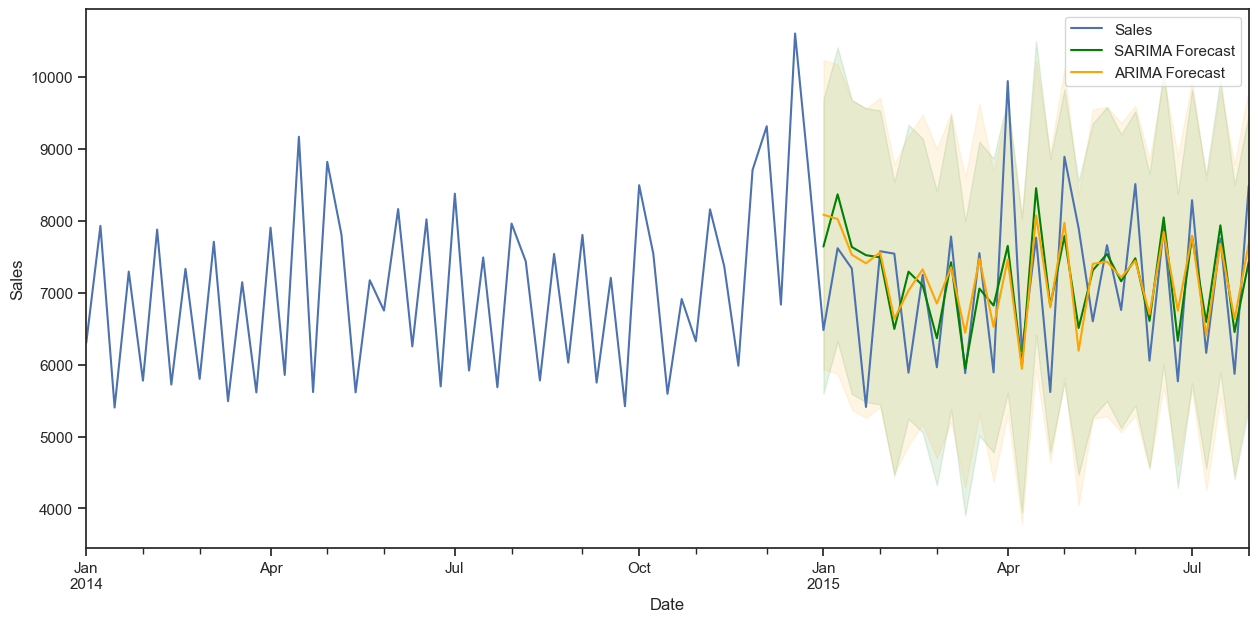

Model Performence Metrics:
              RMSE         MAE       MAPE
ARIMA   933.059988  721.850721  10.510211
SARIMA   909.10972  722.735811  10.382784

            ARIMA Forecast  SARIMA Forecast     Observed
Date                                                    
2015-01-04     8084.720474      7642.819661  6481.154089
2015-01-11     8024.976117      8368.748062  7619.166380
2015-01-18     7528.911847      7636.376967  7337.628746
2015-01-25     7409.314683      7522.299976  5411.591404
2015-02-01     7561.052005      7491.713110  7577.343330
2015-02-08     6637.177230      6496.456206  7543.427399
2015-02-15     7030.034813      7292.725150  5889.046071
2015-02-22     7325.595555      7100.743580  7249.448364
2015-03-01     6849.585853      6366.828278  5963.368673
2015-03-08     7353.779528      7423.254172  7782.020006
2015-03-15     6444.329471      5948.151899  5881.719016
2015-03-22     7474.526009      7057.454440  7551.412133
2015-03-29     6525.319198      6821.941592  589

In [21]:
ax = df_arima['2014':].plot(label='Observed', figsize=(15, 7))
pred_sarima.predicted_mean.plot(ax=ax, label='SARIMA Forecast', alpha=1, color='green')
ax.fill_between(pred_sarima.conf_int().index, pred_sarima.conf_int().iloc[:, 0], pred_sarima.conf_int().iloc[:, 1], color='green', alpha=.1)
pred_arima.predicted_mean.plot(ax=ax, label='ARIMA Forecast', alpha=1, color='orange')
ax.fill_between(pred_arima.conf_int().index, pred_arima.conf_int().iloc[:, 0], pred_arima.conf_int().iloc[:, 1], color='orange', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

print("Model Performence Metrics:")
print(stat_df)
print( )
forecast_df = pd.DataFrame({'ARIMA Forecast': train_arima_forecasted, 'SARIMA Forecast': train_sarima_forecasted, 'Observed': train_sarima_truth['Sales']})
print(forecast_df)


